In [9]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
sb.set()

In [29]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'


def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result


def get_metrics_internal(result, line):
    metrics = line.split(",")
    for metric in metrics:
        name, value = metric.split(":")
        result[name.strip()] = float(value.strip())
    return result 

def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
                epoch = 0
            if 'val_ndcg_at_40' in line:
                    epoch += 1
                    epoch_metrics = get_metrics(line)
                    epoch_metrics['epoch'] = epoch
            if 'best_ndcg' in line:
                epoch_metrics = get_metrics_internal(epoch_metrics, line)
                metrics.append(epoch_metrics)

            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [30]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [31]:
data = get_data_from_logs(experiment_logs, 0)

In [38]:
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')
df1 = df[df.index.to_series().apply(lambda x: x not in [])]

In [39]:
experiment2_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'
data2 = get_data_from_logs(experiment2_logs, 0)
df2 = pd.DataFrame(data2).set_index('model_name').sort_values('ndcg@40')
df2 = df2[df1.columns]
df2 = df2[df2.index.to_series().apply(lambda x: x in ['lightfm_recommender_30_warp', 'APREC-GMLPHE-BPR', 'APREC-GMLPHE-BCE'])]


In [40]:
full_result = pd.concat([df1, df2]).sort_values('ndcg@40')
full_result

,ndcg@40,precision@5,recall@5,SPS@10,MRR,MAP@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,,,,,
random_recommender,0.000713,0.000050,0.000250,0.000750,0.000346,0.000113,13273.716004,0.000516,0.001477,37.544555,{},[]
Transformer-BPR,0.008026,0.000750,0.003751,0.006752,0.004939,0.001891,655.702851,0.033148,22580.734609,127.935947,"{'epochs_trained': 33, 'best_val_ndcg': 0.0124...","[{'loss': 53302.4453, 'ndcg_at_40': 0.0201, 'v..."
top_recommender,0.040632,0.006452,0.032258,0.049512,0.024491,0.018559,12.796424,0.286780,0.025744,6.150706,{'proxy_model': 'filter_seen_recommender'},[]
svd_recommender,0.066512,0.009302,0.046512,0.082271,0.037351,0.028014,67.918030,0.222342,28.748928,177.004232,{'proxy_model': 'filter_seen_recommender'},[]
lightfm_recommender_30_warp,0.068957,0.009150,0.045750,0.082250,0.038802,0.029343,968.668200,0.082849,552.217713,41.827747,{'proxy_model': 'filter_seen_recommender'},[]
BERT4rec-default,0.081886,0.012553,0.062766,0.101275,0.046967,0.036247,447.324431,0.133658,6136.064746,19.267458,{'proxy_model': 'filter_seen_recommender'},[]
APREC-GMLPHE-BPR,0.092056,0.012900,0.064500,0.103500,0.052000,0.039373,145.012775,0.176811,19944.790260,124.703356,"{'epochs_trained': 117, 'best_val_ndcg': 0.073...","[{'loss': 22830.9023, 'ndcg_at_40': 0.1004, 'v..."
APREC-GMLPHE-BCE,0.101513,0.015600,0.078000,0.130000,0.060746,0.049540,381.304500,0.116140,9890.285942,125.106212,"{'epochs_trained': 364, 'best_val_ndcg': 0.087...","[{'loss': 0.0118, 'ndcg_at_40': 0.0852, 'val_l..."
BERT4rec-200000,0.124551,0.019305,0.096524,0.154539,0.074731,0.061414,475.748212,0.114608,15799.525394,18.256569,{'proxy_model': 'filter_seen_recommender'},[]


0 dict_keys([0])
1 dict_keys([0, 1])


<Figure size 1152x648 with 0 Axes>

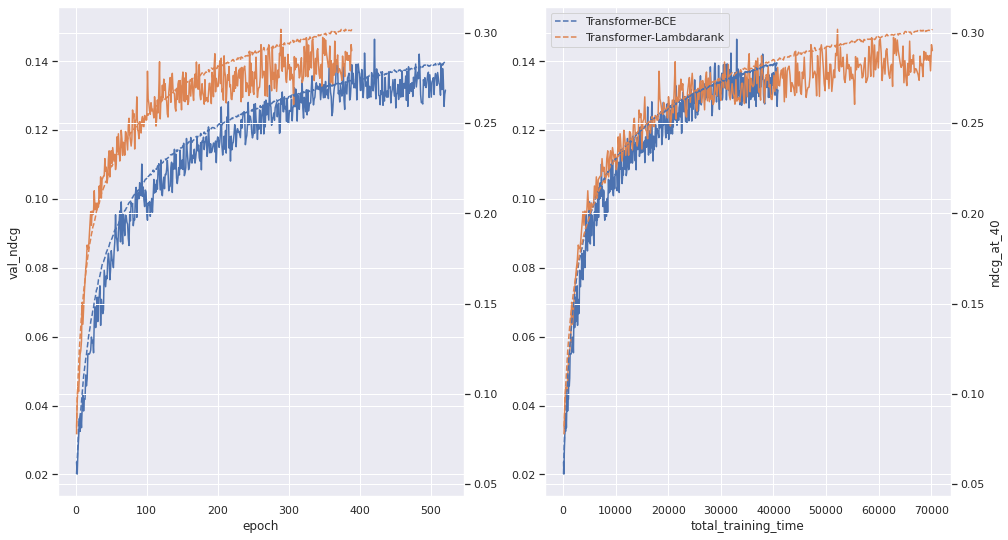

In [42]:
moving_average_steps=1
max_points = 30000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['Salrec-Lambdarank', 'Salrec-BCE', 'Transformer-BCE', 'Transformer-Lambdarank', 'Transformer-Lambdarank-4', 'Transformer-BCE-4']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_40'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [43]:
len(metric), len(metric) - np.argmax(metric) - 1

(389, 100)

In [44]:
max(metric)

0.14932507276535034